Project 3 House Dataset

Goals of this project:
Use machine learning
Gain insight into the data that can be useful
Not trying to develop the best overall model, but a good specific model that is useable
Market Audience:
Home appraiser
House Flipper (looking on insights for purchasing or what to add improve for sell)
Real Estate agent looking for a quick model for helping owners improve sellability
Tools:
Python
?????
packages (see below in import statements)

## Descriptive Modeling
Step 1:
Approaching from a house flipper:
Do certain neighborhoods have better opportunity for flipping?
- low to high price in neighborhood?
- easy remedy to increase price (i.e. pave driveway? convert basement to bedroom, etc...?
- difference between well maintained and poor maintained house?
- remodel kitchen?

## Step 2: Get the Data
- do I need more data? like -
- - Housing index
- - Mortgage rates
- - Length of time to sell
- - Schools
- - Tax rate (assuming all rates are the same for year of sell because all are within Ames City Limits

In [3]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
    recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.pipeline import make_pipeline

# set display options
pd.set_option('display.max_columns', None)
%matplotlib inline

In [ ]:
# load data

train=pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

data_list = [train, test, sample]

## Step 3: Missing Data

In [ ]:
# Quick look at the missing
for lst in data_list:
    print('*' * 80)
    print('Data Head - ')
    print(lst.head()) 
    missing_values_col = lst.isna().sum()
    print("Columns with missing data counts")
    print(missing_values_col.sort_values(ascending=False))
    missing_values = lst.isna().sum().sum()
    print("Shape: ", lst.shape)
    print("Total Missing: ", missing_values)
    print("Percent Missing: ", missing_values / (lst.shape[0]*lst.shape[1]) * 100)
    print('*' * 80)

From above, both test and learning data have some missing data that needs to be addressed. Based on the data documentation, it looks like most of the missing can be attributed to no value.



In [ ]:
'''I notice above that we have 81 columns in train vs 80 in test, 
I assume that is the salesprice column, but will double check.'''

set(train.columns) - set(test.columns)

In [ ]:
# A function for finding missing value counts
def find_missing (df):
    missing_values_col = df.isna().sum()
    print(missing_values_col.sort_values(ascending=False))
    return missing_values_col

In [ ]:
# setup the data for train x,y and test
train_x = train.iloc[:,:-1]
test_x = test
test_y = sample
train_y = train.iloc[:,-1]

find_missing(train_x)
find_missing(test_x)

In [ ]:
#From looking at above and the dataset description, these features with missing data can 
# be changed to 'NA'
replace_na_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
                  'GarageQual', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageYrBlt',
                  'GarageQual', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
                  'BsmtFinType2'
                 ]
def change_missing(df, col_=replace_na_col, val='NA'):
    df[col_] = df[col_].replace({np.nan: val})
    return df
    

In [ ]:
train_x = change_missing(train_x)
test_x = change_missing(test_x)

In [ ]:
find_missing(train_x)
find_missing(test_x)

## Changing from object to category type

In [ ]:
# function to make change and return dataframe
def make_the_change(df, type_from, type_to='category'):
    for col_ in df.drop(['Id'], axis=1):
        if df[col_].dtype in type_from:
            df[col_] = df[col_].astype(type_to)
    return df


In [ ]:
train_x = make_the_change(train_x, ['object', 'int64', 'float64'])
test_x =  make_the_change(train_x, ['object', 'int64', 'float64'])

In [ ]:
train_x.dtypes

## Bin the sales price

In [ ]:
bin_1 = np.linspace(25000, 450000, 18) 
bin_2 = np.array([500000, 550000, 600000, 800000])
bin_ = np.concatenate((bin_1, bin_2))
bin_

In [ ]:
train_y

In [ ]:
train_y_cut = pd.cut(train_y, bins=bin_).astype('category')#np.linspace(25000, 775000, 31))#, right=False)#[col+'_low', col+'_mid', col+'_high', col+'_very_high'])
test_y_cut = pd.cut(test_y['SalePrice'], bins=bin_).astype('category')

#train_y['SalePrice_cut'] # = train_x['SalePrice_cut'].astype('category')

In [ ]:
train_y_cut
test_y_cut

In [ ]:
# taking care of missing values
fields_ = ['MasVnrArea', 'Electrical', 'MSZoning', 'Functional', 'Utilities']
val_ = []
for f in (fields_):
    #val_.append([train_x[f].mode()[0]])
    train_x[f] = train_x[f].fillna(train_x[f].mode()[0])
    test_x[f] = test_x[f].fillna(test_x[f].mode()[0])
    print(f, train_x[f].mode()[0])



In [ ]:
for col_ in train_x.columns:
    train_x[col_]=train_x[col_].astype('str')
for col_ in test_x.columns:
    test_x[col_]=test_x[col_].astype('str')

train_x['MasVnrArea']=train_x['MasVnrArea'].astype('str')
test_x['MasVnrArea']=test_x['MasVnrArea'].astype('str')

In [ ]:
find_missing(test_x)

## Some Aggregate Data       

In [ ]:
neigh = test_x['Neighborhood'].unique()
neigh

agg_data_by_Neighborhood = train.groupby('Neighborhood')['SalePrice'] \
    .agg(['mean', 'median', 'max', 'min', 'count']).sort_values('mean')

agg_data_by_Neighborhood['dif']= agg_data_by_Neighborhood['max']-agg_data_by_Neighborhood['min']
agg_data_by_Neighborhood

In [ ]:



train_x.groupby(['Neighborhood']).agg(lambda x: stats.mode(x)[0])#.mode()

## Lets give it a go! some forest time

In [ ]:
train_x = a
train_y = c
test_x = b
test_y = d

In [ ]:

col_trans = make_column_transformer(
                        (OneHotEncoder(),train_x.columns.tolist()),
                        remainder = "passthrough"
                        )

In [ ]:
set(train_x.columns) - set(test_x.columns)

In [ ]:
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=10,
                      n_estimators=5000,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=22,
                      max_features=5)

In [ ]:
#train_x=train_x.drop(['index'])

pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(train_x, train_y)

In [ ]:
find_missing(b)

In [ ]:
unique_counts(train_x)

In [ ]:
ff = unique_counts(test_x)

In [ ]:
print(ff)

In [ ]:
test_x['MSZoning'].unique

In [ ]:
y_pred = pipe.predict(test_x)

In [ ]:
accuracy_score(test_y['SalePrice'].astype('str'), y_pred)

In [ ]:
y_pred

In [ ]:
confusion_matrix(test_y['SalePrice'].astype('int'), y_pred)

In [ ]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

In [ ]:
print(col_trans.fit_transform(train_x)[0,:])

In [ ]:
train_x.iloc[0,:] 

In [ ]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(train_x, train_x.columns.tolist())

In [ ]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))


# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];



In [ ]:
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [ ]:

print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

In [ ]:

n_estimators = [int(x) for x in np.linspace(start = 2, stop = 1000, num = 200)]
max_features = ['auto', 'log2', 3]  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 10, num = 9)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

In [ ]:
train_x = a
test_x = b
train_y =c
test_y = d

In [ ]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 50, cv = 3,
                verbose=1, random_state=22,
                scoring='accuracy')
pipe_random = make_pipeline(col_trans, rf_random)
pipe_random.fit(train_x, train_y)
rf_random.best_params_

In [ ]:
best_model = rf_random.best_estimator_
pipe_best_model = make_pipeline(col_trans, best_model)
pipe_best_model.fit(train_x, train_y)
y_pred_best_model = pipe_best_model.predict(test_x)

In [ ]:
best_model

In [ ]:
best_model.feature_importances_

feature_importances = list(zip(X_train_encoded, best_model.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

In [ ]:
# To look at nodes and depths of trees use on average
n_nodes = []
max_depths = []
for ind_tree in best_model.estimators_:
       n_nodes.append(ind_tree.tree_.node_count)
       max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')   
print(f'Average maximum depth {int(np.mean(max_depths))}')  




In [ ]:
y_test = test_y.astype('str')
x_test = test_x

train_rf_predictions = pipe_best_model.predict(train_x)
train_rf_probs = pipe_best_model.predict_proba(train_x)[:, 1]
rf_probs = pipe_best_model.predict_proba(test_x)[:, 1]
# Plot ROC curve and check scores
evaluate_model(y_pred_best_model, rf_probs, train_rf_predictions, train_rf_probs)

In [ ]:
print(train_rf_predictions)
print(train_rf_probs)

In [ ]:

def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    #baseline['accuracy'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    #results['accuracy'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    #train_results['accuracy'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision']:#, 'accuracy']:  
          print(f'{metric.capitalize()} \
                 Baseline: {round(baseline[metric], 2)} \
                 Test: {round(results[metric], 2)} \
                 Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), \
             fontsize = 20, \
             horizontalalignment="center", \
             color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Stay', '1 - Exit'],
                      title = 'Exit_status Confusion Matrix')

In [32]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

[0.00000000e+00 1.35588206e-03 1.26187393e-05 8.95845972e-03
 1.14622962e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.72572680e-03 1.98454717e-04 0.00000000e+00
 7.12380559e-03 3.99496653e-04 3.34032279e-04 1.22970332e-04
 1.34807772e-03 6.68097317e-04 3.78114495e-04 2.07637072e-06
 3.16043527e-04 0.00000000e+00 9.13874926e-04 6.34617643e-04
 1.25509579e-04 4.49890972e-03 7.55409917e-04 2.42402110e-03
 6.20270565e-03 5.65797702e-04 4.51426819e-04 8.12742479e-04
 6.96803397e-03 0.00000000e+00 2.79520813e-03 2.42623077e-03
 3.49254279e-03 4.61928262e-03 1.35211142e-04 3.17027861e-03
 4.57971260e-04 2.29820117e-03 1.99456307e-04 2.97530429e-04
 0.00000000e+00 6.08565502e-03 8.27559728e-05 1.08762633e-03
 9.17220035e-04 1.65110692e-03 2.59841770e-03 2.29410830e-05
 5.08202109e-03 0.00000000e+00 0.00000000e+00 8.54226314e-03
 8.41536984e-04 1.39935264e-03 0.00000000e+00 2.48231548e-04
 0.00000000e+00 4.73848801e-04 8.31746880e-03 2.28126951e-02
 1.10113427e-02 1.937705

In [34]:
rf_classifier.decision_path

<bound method BaseForest.decision_path of RandomForestClassifier(max_features=5, min_samples_leaf=10, n_estimators=5000,
                       n_jobs=-1, oob_score=True, random_state=22)>

In [ ]:
train_y.append(test_y, ignore_index=True)

In [ ]:
type(test_y)



starting from the top! way too many categories to make sense of the data...
eliminate some items that aren't relevent to our needs. Decrease the number data into smaller groups.

def unique_counts (df):
    ret = []
    ret = pd.DataFrame.from_records([(col, df[col].nunique(), df[col].dtype) for col in df.columns],
                          columns=['Column', 'Num_Unique', 'type']).sort_values(by=['Num_Unique'])
    return ret

def convert_to_cat(df, type_):
    unique_ = unique_counts(df)
    for col in unique_['Column'].loc[unique_['Num_Unique']<20]:
        if df[col].dtype == type_:
            #if unique_[col].loc[unique_['Num_Unique']<20]:
        #train_x[col] = pd.cut(train_x[col], bins=4, labels=[col+'_low', col+'_mid', col+'_high', col+'_very_high'])
            df[col] = df[col].astype('str').astype('category')
    for col in unique_['Column'].loc[unique_['Num_Unique']>=20]:
        if df[col].dtype == type_:
            df[col] = pd.qcut(df[col], 4)#bins=4, labels=['_low', '_mid', '_high', '_very_high'])
            df[col] = df[col].astype('str').astype('category')
    return df
        



In [2]:
# create a setup function that gets the data in the structure I need
replace_na_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
                  'GarageQual', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageYrBlt',
                  'GarageQual', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
                  'BsmtFinType2'
                 ]

def unique_counts (df):
    ret = []
    ret = pd.DataFrame.from_records([(col, df[col].nunique(), df[col].dtype) for col in df.columns],
                          columns=['Column', 'Num_Unique', 'type']).sort_values(by=['Num_Unique'])
    return ret

def convert_to_cat(df, type_):
    unique_ = unique_counts(df)
    for col in unique_['Column'].loc[unique_['Num_Unique']<20]:
        if df[col].dtype == type_:
            #if unique_[col].loc[unique_['Num_Unique']<20]:
        #train_x[col] = pd.cut(train_x[col], bins=4, labels=[col+'_low', col+'_mid', col+'_high', col+'_very_high'])
            df[col] = df[col].astype('str').astype('category')
    for col in unique_['Column'].loc[unique_['Num_Unique']>=20]:
        if df[col].dtype == type_:
            df[col] = pd.qcut(df[col], 4)#bins=4, labels=['_low', '_mid', '_high', '_very_high'])
            df[col] = df[col].astype('str').astype('category')
    return df


def change_missing(df, col_=replace_na_col, val='NA'):
    df[col_] = df[col_].replace({np.nan: val})
    return df


def data_load():
    
    train=pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    sample = pd.read_csv('sample_submission.csv')
    test.loc[1358, 'MSSubClass'] = '160'
    train_x = train.iloc[:,:-1].drop('Id', axis=1)
    test_x = test.drop('Id', axis=1)
    
  #
    fields_ = ['MasVnrArea', 'Electrical', 'MSZoning', 'Functional', 'Utilities']
    for col_ in test_x.columns:
        test_x.loc[test_x[col_]=='nan'][col_] = ''#''
    val_ = []
    for f in (fields_):
    #val_.append([train_x[f].mode()[0]])
        train_x[f] = train_x[f].fillna(train_x[f].mode()[0])
        test_x[f] = test_x[f].fillna(test_x[f].mode()[0])
    print(f, train_x[f].mode()[0])
 #
    test_y = sample
    train_y = train.iloc[:,-1]
    train_x = change_missing(train_x)
    test_x = change_missing(test_x)
    #
     
    # bin y
    bin_ = np.concatenate((np.linspace(25000, 450000, 18),np.array([500000, 550000, 600000, 800000]) ) )
    train_y = pd.cut(train_y, bins=bin_).astype('str').astype('category')
    test_y = pd.cut(test_y['SalePrice'], bins=bin_).astype('str').astype('category')
    # change object type to str category
    for col in train_x:
        if train_x[col].dtype == 'object':
            train_x[col] = train_x[col].astype('str').astype('category')
    for col in test_x:
        if test_x[col].dtype == 'object':
            test_x[col] = test_x[col].astype('str').astype('category')
    # bin the bigger types
    train_x = convert_to_cat(train_x, 'int64')
    test_x = convert_to_cat(test_x, 'int64')
    train_x = convert_to_cat(train_x, 'float64')
    test_x = convert_to_cat(test_x, 'float64')
    #dropping fields that aren't adding value
    fields_to_drop = ['LotFrontage', 'GarageYrBlt', 'Utilities', 'Street', 'GarageArea',
                      'YearRemodAdd', 'BsmtFinSF1', 'ScreenPorch', 'EnclosedPorch', 'Alley',
                      'Utilities', 'SaleType', '3SsnPorch', 'Exterior1st', 'Exterior2nd',
                      'Condition1', 'Condition2', 'PoolArea', 'Functional', 'RoofMatl',
                      'RoofStyle', 'Electrical', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
                      'PoolQC', 'HeatingQC', 'BsmtExposure', 'PoolQC', 'BsmtUnfSF', 
                      'SaleCondition', 'LotConfig', 'TotalBsmtSF', 'MSSubClass', 'LowQualFinSF',
                      'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'WoodDeckSF', 'WoodDeckSF'
                     ]
    #test_x = test_x.drop('LotFrontage', axis=1)
    #train_x = train_x.drop('LotFrontage', axis=1)
    test_x = test_x.drop(fields_to_drop, axis=1)
    train_x = train_x.drop(fields_to_drop, axis=1)
    
    return train_x, test_x, train_y, test_y


In [42]:
a,b,c,d = data_load()

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/p

Utilities AllPub


TypeError: qcut() got an unexpected keyword argument 'bins'

In [11]:
df = a
unique_counts_a = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column', 'Num_Unique']).sort_values(by=['Num_Unique'])
df=b
unique_counts_b = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column', 'Num_Unique']).sort_values(by=['Num_Unique'])

new_ = pd.merge(unique_counts_a, unique_counts_b, on='Column')
print(new_)

          Column  Num_Unique_x  Num_Unique_y
0     CentralAir             2             2
1       HalfBath             3             3
2      LandSlope             3             3
3        MiscVal             3             4
4     PavedDrive             3             3
5       2ndFlrSF             4             4
6       1stFlrSF             4             4
7   KitchenAbvGr             4             3
8    KitchenQual             4             5
9     Fireplaces             4             5
10  GarageFinish             4             4
11     ExterQual             4             4
12     GrLivArea             4             4
13      FullBath             4             5
14     YearBuilt             4             4
15   OpenPorchSF             4             4
16   LandContour             4             4
17      LotShape             4             4
18       LotArea             4             4
19    MasVnrArea             4             4
20         Fence             5             5
21   MiscF

In [35]:
train_x = a
train_y = c
test_x = b
test_y = d

col_trans = make_column_transformer(
                        (OneHotEncoder(),train_x.columns.tolist()),
                        remainder = "passthrough"
                        )
set(test_x.columns) - set(train_x.columns)


rf_classifier = RandomForestClassifier(
                      min_samples_leaf=10,
                      n_estimators=5000,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=22,
                      max_features=5)


pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(train_x, train_y)

#y_pred = pipe.predict(test_x)
#accuracy_score(test_y['SalePrice'].astype('str'), y_pred)


print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")



def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(train_x, train_x.columns.tolist())


feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))


# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];





[0.00000000e+00 1.35588206e-03 1.26187393e-05 8.95845972e-03
 1.14622962e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.72572680e-03 1.98454717e-04 0.00000000e+00
 7.12380559e-03 3.99496653e-04 3.34032279e-04 1.22970332e-04
 1.34807772e-03 6.68097317e-04 3.78114495e-04 2.07637072e-06
 3.16043527e-04 0.00000000e+00 9.13874926e-04 6.34617643e-04
 1.25509579e-04 4.49890972e-03 7.55409917e-04 2.42402110e-03
 6.20270565e-03 5.65797702e-04 4.51426819e-04 8.12742479e-04
 6.96803397e-03 0.00000000e+00 2.79520813e-03 2.42623077e-03
 3.49254279e-03 4.61928262e-03 1.35211142e-04 3.17027861e-03
 4.57971260e-04 2.29820117e-03 1.99456307e-04 2.97530429e-04
 0.00000000e+00 6.08565502e-03 8.27559728e-05 1.08762633e-03
 9.17220035e-04 1.65110692e-03 2.59841770e-03 2.29410830e-05
 5.08202109e-03 0.00000000e+00 0.00000000e+00 8.54226314e-03
 8.41536984e-04 1.39935264e-03 0.00000000e+00 2.48231548e-04
 0.00000000e+00 4.73848801e-04 8.31746880e-03 2.28126951e-02
 1.10113427e-02 1.937705

In [40]:
for col_ in a.columns:
    print(a.groupby(col_)['YrSold'].agg('count'))

MSZoning
C (all)      10
FV           65
RH           16
RL         1151
RM          218
Name: YrSold, dtype: int64
LotArea
LotArea_high            2
LotArea_low          1453
LotArea_mid             3
LotArea_very_high       2
Name: YrSold, dtype: int64
LotShape
IR1    484
IR2     41
IR3     10
Reg    925
Name: YrSold, dtype: int64
LandContour
Bnk      63
HLS      50
Low      36
Lvl    1311
Name: YrSold, dtype: int64
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: YrSold, dtype: int64
Neighborhood
Blmngtn     17
Blueste      2
BrDale      16
BrkSide     58
ClearCr     28
CollgCr    150
Crawfor     51
Edwards    100
Gilbert     79
IDOTRR      37
MeadowV     17
Mitchel     49
NAmes      225
NPkVill      9
NWAmes      73
NoRidge     41
NridgHt     77
OldTown    113
SWISU       25
Sawyer      74
SawyerW     59
Somerst     86
StoneBr     25
Timber      38
Veenker     11
Name: YrSold, dtype: int64
BldgType
1Fam      1220
2fmCon      31
Duplex      52
Twnhs       43
TwnhsE     114
Name: 

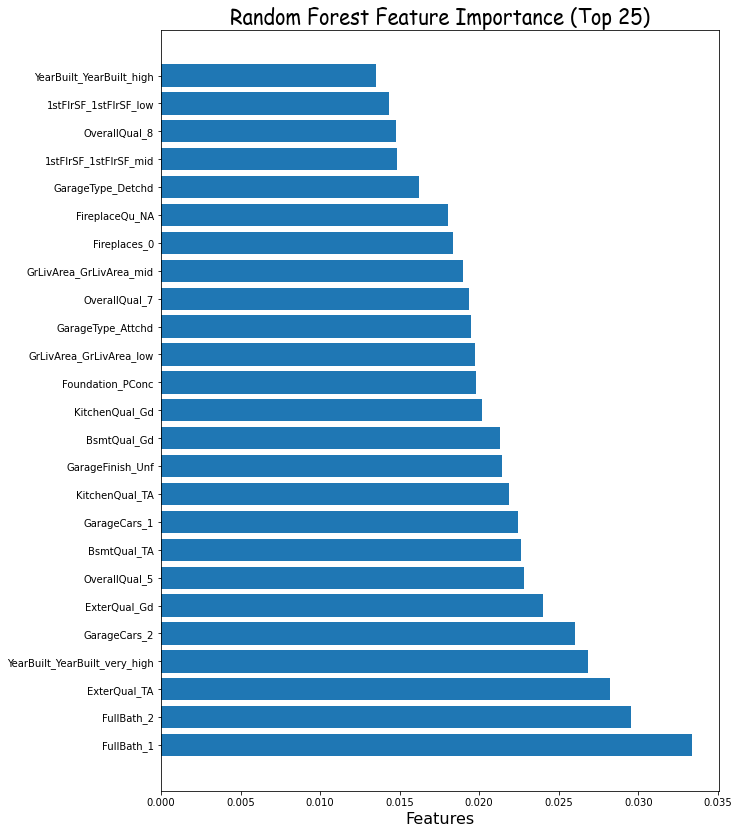

In [13]:
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [14]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 1000, num = 200)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 10, num = 9)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

In [15]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 50, cv = 3,
                verbose=1, random_state=22,
                scoring='accuracy')
pipe_random = make_pipeline(col_trans, rf_random)
pipe_random.fit(train_x, train_y)
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only avai

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "

{'n_estimators': 147,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 37,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [19]:
# To look at nodes and depths of trees use on average
n_nodes = []
max_depths = []
for ind_tree in best_model.estimators_:
       n_nodes.append(ind_tree.tree_.node_count)
       max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')   
print(f'Average maximum depth {int(np.mean(max_depths))}')  


Average number of nodes 73
Average maximum depth 9


In [18]:
best_model = rf_random.best_estimator_
pipe_best_model = make_pipeline(col_trans, best_model)
pipe_best_model.fit(train_x, train_y)
y_pred_best_model = pipe_best_model.predict(train_x)

In [30]:
for i, v in enumerate(test_x.columns):
    print(i, v)

0 MSZoning
1 LotArea
2 LotShape
3 LandContour
4 LandSlope
5 Neighborhood
6 BldgType
7 HouseStyle
8 OverallQual
9 OverallCond
10 YearBuilt
11 MasVnrType
12 MasVnrArea
13 ExterQual
14 ExterCond
15 Foundation
16 BsmtQual
17 BsmtCond
18 Heating
19 CentralAir
20 1stFlrSF
21 2ndFlrSF
22 GrLivArea
23 FullBath
24 HalfBath
25 BedroomAbvGr
26 KitchenAbvGr
27 KitchenQual
28 TotRmsAbvGrd
29 Fireplaces
30 FireplaceQu
31 GarageType
32 GarageFinish
33 GarageCars
34 GarageQual
35 GarageCond
36 PavedDrive
37 OpenPorchSF
38 Fence
39 MiscFeature
40 MiscVal
41 MoSold
42 YrSold


In [31]:
train_rf_predictions = pipe_best_model.predict(train_x)
train_rf_probs = pipe_best_model.predict_proba(train_x)[:, 1]
rf_probs = pipe_best_model.predict_proba(train_x)[:, 1]
# Plot ROC curve and check scores
print(y_pred_best_model, rf_probs, train_rf_predictions, train_rf_probs)

['(175000.0, 200000.0]' '(150000.0, 175000.0]' '(175000.0, 200000.0]' ...
 '(125000.0, 150000.0]' '(125000.0, 150000.0]' '(125000.0, 150000.0]'] [0.02933651 0.18419152 0.01851828 ... 0.16204932 0.47548037 0.46439062] ['(175000.0, 200000.0]' '(150000.0, 175000.0]' '(175000.0, 200000.0]' ...
 '(125000.0, 150000.0]' '(125000.0, 150000.0]' '(125000.0, 150000.0]'] [0.02933651 0.18419152 0.01851828 ... 0.16204932 0.47548037 0.46439062]


In [27]:
x_train = train_x
y_train = train_y
x_test = train_x
y_test = train_y

def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} \
                 Baseline: {round(baseline[metric], 2)} \
                 Test: {round(results[metric], 2)} \
                 Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
evaluate_model(y_pred_best_model,rf_probs,train_rf_predictions,train_rf_probs)

ValueError: Mix of label input types (string and number)